#  Q1a

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
df_grad = pd.read_csv('Admission_Predict.csv')
df_grad.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
df_admin_pred = df_grad.copy().drop(columns = ['Serial No.', 'University Rating', 'Chance of Admit '])
df_admin_pred.head()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research
0,337,118,4.5,4.5,9.65,1
1,324,107,4.0,4.5,8.87,1
2,316,104,3.0,3.5,8.00,1
3,322,110,3.5,2.5,8.67,1
4,314,103,2.0,3.0,8.21,0


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_admin_pred.values)
ar_inputs_nml = scaler.transform(df_admin_pred.values)

In [5]:
df_admin_nml = pd.DataFrame(ar_inputs_nml, columns = df_admin_pred.columns)
df_admin_nml.head()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research
0,1.819238,1.778865,1.137360,1.098944,1.776806,0.886405
1,0.667148,-0.031601,0.632315,1.098944,0.485859,0.886405
2,-0.041830,-0.525364,-0.377773,0.017306,-0.954043,0.886405
3,0.489904,0.462163,0.127271,-1.064332,0.154847,0.886405
4,-0.219074,-0.689952,-1.387862,-0.523513,-0.606480,-1.128152


## Q1b

## Reference code for a simple perceptron
reference [Neural Networks and Deep Learning, Ch. 2](http://neuralnetworksanddeeplearning.com/chap2.html)

In [7]:
def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1-np.tanh(x)**2

In [8]:
class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### initialize parameters ###
        self.weights= [np.random.random() * 0.05 for i in range(self.input_dim)]
        self.biases= np.random.random() * 0.05

    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ###
        #print(X.shape, self.weights, self.biases)
        self.z = (np.dot(X, self.weights)) + self.biases              #shape(X.shape[0],1)
        self.a = self.activation(self.z)                              #shape(X.shape[0],1)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        self.predict(X)
        errors=np.squeeze((self.a-y)*self.activation_grad(self.z))
        weights_grad=errors.dot(X) # errors.T.dot(X)
        bias_grad=np.sum(errors,axis=0)
        ### Update weights and biases from the gradient ###
        self.weights -= (2 * self.lr * weights_grad)
        self.biases -= (2 * self.lr * bias_grad)
        #print(self.biases, self.weights)
        #return self.biases

        
    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        #print(X[order[n*batch_size:]].shape, y[order[n*batch_size:]].shape )
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])
        
    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        return np.mean(np.square(self.predict(X) - y))
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.biases=weights[1]

In [9]:
y = df_grad['Chance of Admit '].values
y[:12]

array([0.92, 0.76, 0.72, 0.8 , 0.65, 0.9 , 0.75, 0.68, 0.5 , 0.45, 0.52,
       0.84])

In [10]:
percept = simple_perceptron(6,1, 0.01, tanh, tanh_grad)
percept.fit(df_admin_nml.values[:34], y[:34])

In [11]:
percept = simple_perceptron(6,1, 0.01, tanh, tanh_grad)
vals = percept.train_on_epoch(df_admin_nml.values[:44], y[:44])

## Q1c

In [12]:
from sklearn.model_selection import train_test_split,KFold


def Kfold(k,Xs,ys,epochs,input_dim, learning_rate=0.0001,draw_curve=True):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        test_Xs= Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, test_size= 0.2)
        
        ### Establish the model for simple perceptron here ###
        model= simple_perceptron(input_dim,1,learning_rate, tanh, tanh_grad)
        
        # Save the lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_on_epoch(train_in,train_real)
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        final_epochs= np.where(val_array == np.min(val_array))[0].item()
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error= model.evaluate(train_Xs, train_ys)
        train_error_all.append(train_error)
        test_error= model.evaluate(test_Xs, test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


Number of epochs with lowest validation: 455
Train error: 0.004216629768868329
Test error: 0.004068962649088717
Number of epochs with lowest validation: 993
Train error: 0.004434335381342641
Test error: 0.003276105015637188
Number of epochs with lowest validation: 999
Train error: 0.003926066670674655
Test error: 0.005126743371013515
Number of epochs with lowest validation: 984
Train error: 0.003858252744287036
Test error: 0.005558118775873367
Number of epochs with lowest validation: 971
Train error: 0.004400683598052532
Test error: 0.003330026523843359
Final results:
Training error:0.004167+-0.000237
Testing error:0.004272+-0.000928


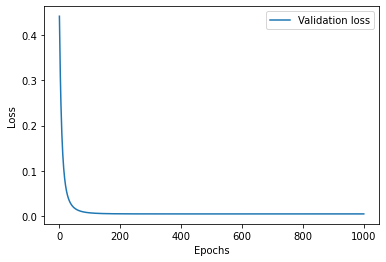

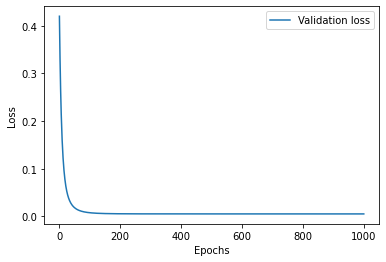

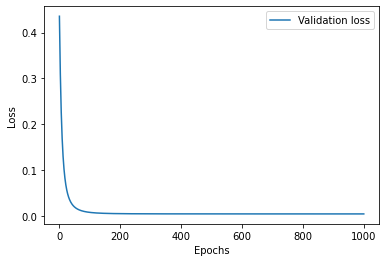

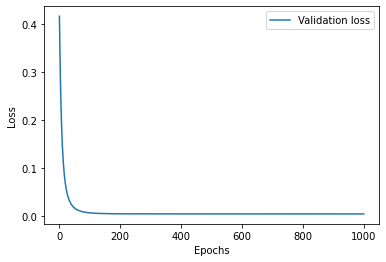

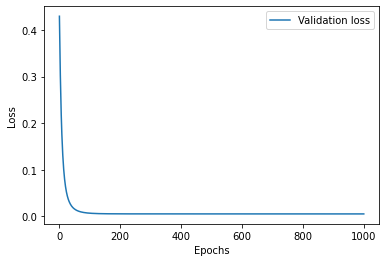

In [13]:
Kfold(5, ar_inputs_nml, y, 1000, 6)

Yes, the features are good indicators for getting into graduate school, evident from the extremely small testing error. 

## Removing the GRE scores feature and Running the Same Test

In [14]:
df_no_gre = df_admin_nml.drop(columns = 'GRE Score')
df_no_gre

,TOEFL Score,SOP,LOR,CGPA,Research
0,1.778865,1.137360,1.098944,1.776806,0.886405
1,-0.031601,0.632315,1.098944,0.485859,0.886405
2,-0.525364,-0.377773,0.017306,-0.954043,0.886405
3,0.462163,0.127271,-1.064332,0.154847,0.886405
4,-0.689952,-1.387862,-0.523513,-0.606480,-1.128152
...,...,...,...,...,...
495,0.132987,1.137360,0.558125,0.734118,0.886405
496,1.614278,1.642404,1.639763,2.140919,0.886405
497,2.108041,1.137360,1.639763,1.627851,0.886405
498,-0.689952,0.632315,1.639763,-0.242367,-1.128152


Number of epochs with lowest validation: 251
Train error: 0.004287803235383308
Test error: 0.005071544316003809
Number of epochs with lowest validation: 976
Train error: 0.0043309070753617665
Test error: 0.0042128641371205295
Number of epochs with lowest validation: 561
Train error: 0.0044383287364473615
Test error: 0.003784896970219262
Number of epochs with lowest validation: 999
Train error: 0.004423739681783545
Test error: 0.003860477930617619
Number of epochs with lowest validation: 998
Train error: 0.004153972248354447
Test error: 0.0051402077888425095
Final results:
Training error:0.004327+-0.000103
Testing error:0.004414+-0.000583


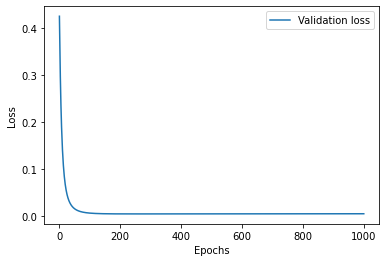

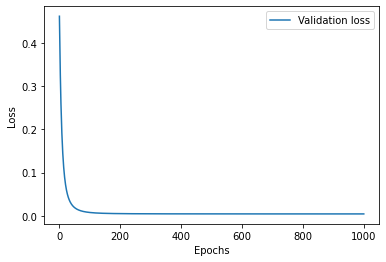

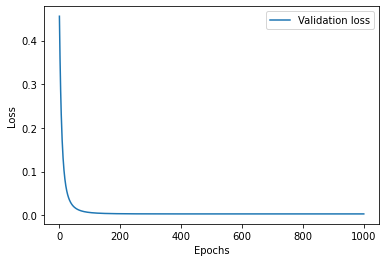

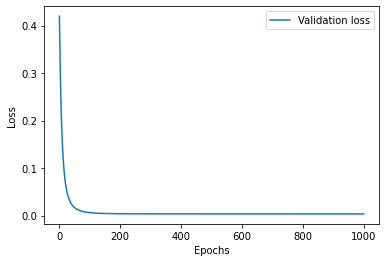

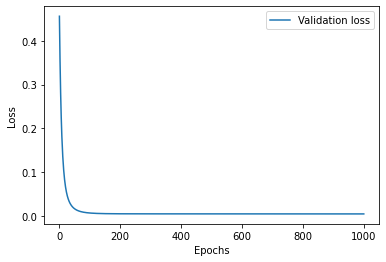

In [15]:
# Using just 5 features since removing GRE feature
Kfold(5, df_no_gre.values, y, 1000, 5)

I am still getting the same amount of test error regardless if the feature dataset contains GRE scores or not, so don't think GRE scores are an important indicator for whether you get into grad school or not.  

## Q2a:

In [16]:
df_titanic = pd.read_csv('titantic.csv')
print(df_titanic.shape)
df_titanic.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
df_titan_filtered = df_titanic.dropna()
df_titan_filtered.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [20]:
df_titanic['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [21]:
df_titan_feats = df_titan_filtered.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
df_titan_feats.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,female,38.0,1,0,71.2833,C
3,1,female,35.0,1,0,53.1000,S
6,1,male,54.0,0,0,51.8625,S
10,3,female,4.0,1,1,16.7000,S
11,1,female,58.0,0,0,26.5500,S


In [22]:
y_surv = df_titan_filtered['Survived'].values
y_surv[:10]

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0])

In [23]:
df_titan_cat = df_titan_feats[['Pclass', 'Sex', 'Embarked']]
df_titan_cat

,Pclass,Sex,Embarked
1,1,female,C
3,1,female,S
6,1,male,S
10,3,female,S
11,1,female,S
...,...,...,...
871,1,female,S
872,1,male,S
879,1,female,C
887,1,female,S


In [24]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(df_titan_cat)
ar_onehot_cats = encoder.transform(df_titan_cat).toarray()
ar_onehot_cats

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [25]:
encoder.categories_

[array([1, 2, 3]),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object)]

In [26]:
cat_col_names = ['Pclass_' + str(i) for i in encoder.categories_[0]] + encoder.categories_[1].tolist() + encoder.categories_[2].tolist()
cat_col_names

['Pclass_1', 'Pclass_2', 'Pclass_3', 'female', 'male', 'C', 'Q', 'S']

In [27]:
df_onehot = pd.DataFrame(ar_onehot_cats, columns = cat_col_names)
df_onehot.head()

,Pclass_1,Pclass_2,Pclass_3,female,male,C,Q,S
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [29]:
scaler.fit(df_titan_feats.drop(columns = ['Pclass', 'Sex', 'Embarked']).values)
ar_titans_nml = scaler.transform(df_titan_feats.drop(columns = ['Pclass', 'Sex', 'Embarked']).values)
ar_titans_nml[:10]

array([[ 0.14906507,  0.83362754, -0.63172982, -0.0971798 ],
       [-0.0432295 ,  0.83362754, -0.63172982, -0.3359971 ],
       [ 1.17463611, -0.7230443 , -0.63172982, -0.35225028],
       [-2.03027338,  0.83362754,  0.69708118, -0.81407038],
       [ 1.43102886, -0.7230443 , -0.63172982, -0.68470165],
       [-0.10732769, -0.7230443 , -0.63172982, -0.86266574],
       [-0.49191683, -0.7230443 , -0.63172982, -0.56715341],
       [-1.06880054,  3.94697121,  2.02589219,  2.42080454],
       [ 0.85414516,  0.83362754, -0.63172982, -0.025654  ],
       [ 1.87971619, -0.7230443 ,  0.69708118, -0.21937875]])

In [30]:
ar_titans_nml.shape

(183, 4)

In [31]:
#Stack the 2 arrays and got array of all feats 
ar_feats = np.hstack((ar_titans_nml, ar_onehot_cats))
ar_feats.shape

(183, 12)

## Q2b:

Number of epochs with lowest validation: 999
Train error: 0.14122852592620336
Test error: 0.16651256301106304
Number of epochs with lowest validation: 999
Train error: 0.1494662557877094
Test error: 0.14539671147362745
Number of epochs with lowest validation: 999
Train error: 0.14727493432486816
Test error: 0.14886817726073123
Number of epochs with lowest validation: 999
Train error: 0.15056745557953333
Test error: 0.14399133716157614
Number of epochs with lowest validation: 700
Train error: 0.13642759778456565
Test error: 0.18752431047677157
Final results:
Training error:0.144993+-0.005363
Testing error:0.158459+-0.016623


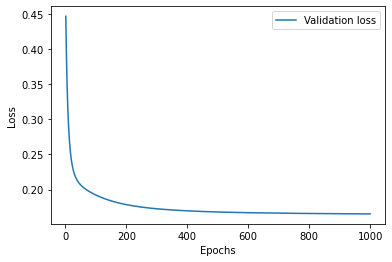

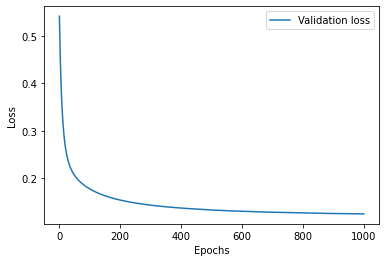

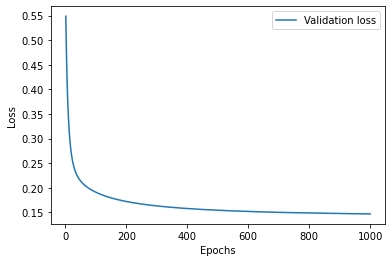

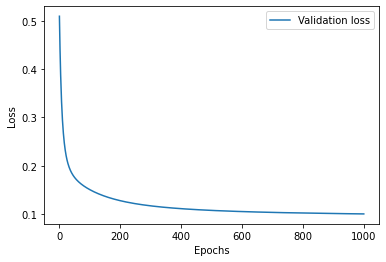

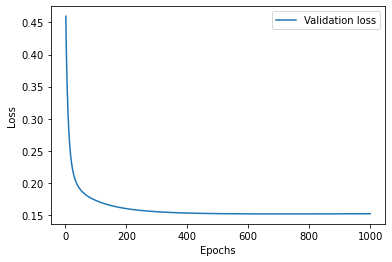

In [32]:
mod_titanic = Kfold(5, ar_feats, y_surv, 1000, 12)

### Predicting who will survive

In [34]:
# Test Loss is around 0.15, and essentially outputting survival probabilities (since output is between 0 to 1) 
# If survival probability is greater than 0.5, assuming the model is predicting it as survived 
df_pred_surv = df_titan_filtered[mod_titanic.predict(ar_feats) > 0.5]
df_pred_surv.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S


In [35]:
df_pred_surv['Survived'].value_counts()

1    105
0     21
Name: Survived, dtype: int64

In [37]:
# Yea, we can predict who will survive and around 83% of the true survivors are predicted accurately
df_pred_surv['Survived'].value_counts()[1] / sum(df_pred_surv['Survived'].value_counts())

0.8333333333333334

Yea, we can predict who will survive and around 80% of the true survivors are predicted accurately

### Playing around with features to determine which ones give a better chance to get back to shore

## Q3a

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)-5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

This is your training data:

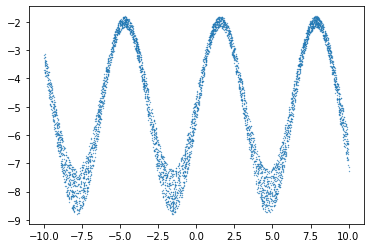

In [51]:
x,y=generate_data(5000,0.1)
plt.scatter(x,y,s=0.1)
x = x.reshape((-1,1))

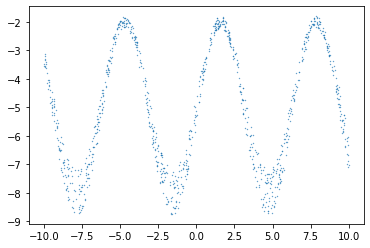

In [52]:
x_test, y_test = generate_data(1000, 0.1)
plt.scatter(x_test, y_test, s = 0.1)

Number of epochs with lowest validation: 999
Train error: 20.583829378016652
Test error: 19.461695658279364
Number of epochs with lowest validation: 999
Train error: 20.183122222380838
Test error: 21.064557638222965
Number of epochs with lowest validation: 999
Train error: 20.249857736643957
Test error: 20.797610338246194
Number of epochs with lowest validation: 999
Train error: 20.29854008974295
Test error: 20.60288088954378
Number of epochs with lowest validation: 999
Train error: 20.481682783325457
Test error: 19.870288268495685
Final results:
Training error:20.359406+-0.149732
Testing error:20.359407+-0.598943


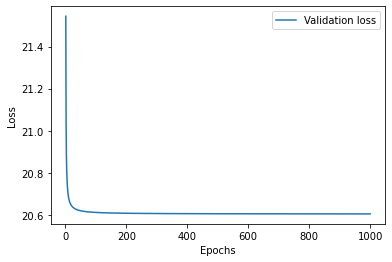

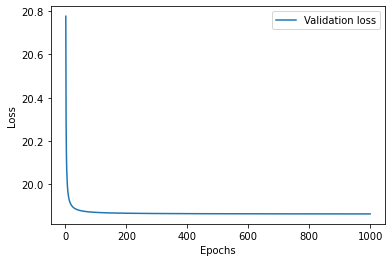

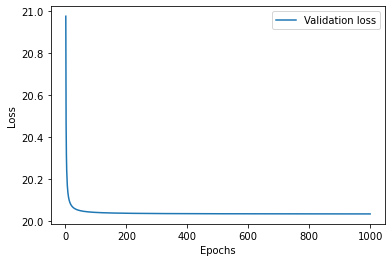

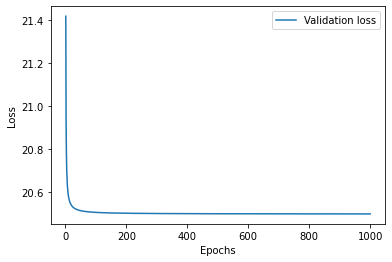

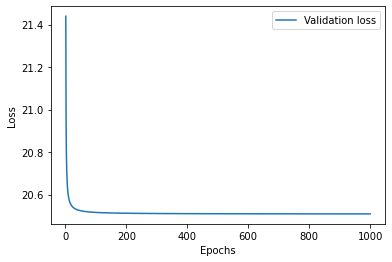

In [42]:
sin_model = Kfold(5,x,y,1000,1)

In [45]:
x_test, y_test = generate_data(1000, stochascity= 0.1)
x_test = x_test.reshape((-1,1))
y_preds_test = sin_model.predict(x_test)

In [46]:
def show_correlation(xs,ys):
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)

Correlation coefficient: 0.21040616683113422


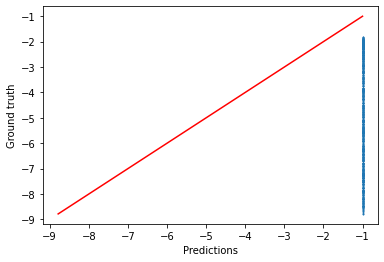

In [47]:
show_correlation(y_preds_test, y_test)

The model's predictions are bad evident from the high test error of 20 and is highlighted even more by the correlation plot revealing that the predictions and ground truth do not match across the entire ground truth range. The low correlation coefficient of 0.21 also supports this critique. 

## (b)

Here we use the Multi-layer Perceptron regressor built-in from sklearn as a simple ANN <br>
[MLP regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [48]:
from sklearn.neural_network import MLPRegressor

def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001,):
    # The total number of examples for training the network
    total_num=len(Xs)

    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_error_all=[]
    test_error_all=[]
    for train_selector,test_selector in kf.split(range(total_num)):
        # Decide training examples and testing examples for this fold
        train_Xs=Xs[train_selector]
        test_Xs= Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        
        # Establish the model here
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hidden_layers).fit(train_Xs, train_ys)
        
        ### Report result for this fold ##
        train_error= np.mean(np.square(model.predict(train_Xs) - train_ys))
        train_error_all.append(train_error)
        test_error= np.mean(np.square(model.predict(test_Xs) - test_ys))
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)

    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


In [53]:
sin_MLP_model = KFold_NN(5,x,y,hidden_layers= 8,epochs=1000,lr=0.001)

/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.6847040037039801
Test error: 0.7353566222612322


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.5104148029922172
Test error: 0.44861424247826676


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.6423560234060751
Test error: 0.6252818762673702


/Users/karthikraj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error: 0.5571013125755708
Test error: 0.5872378987253328
Train error: 2.4488277725406373
Test error: 2.4147252069299303
Final results:
Training error:0.968681+-0.742613
Testing error:0.962243+-0.732007


In [54]:
y_pred_MLP = sin_MLP_model.predict(x_test.reshape(-1,1))

Correlation coefficient: 0.6733913082238877


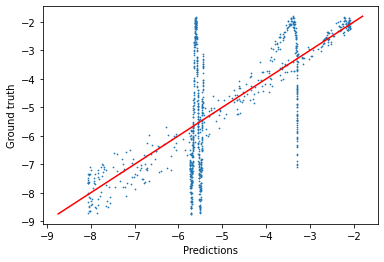

In [55]:
show_correlation(y_pred_MLP, y_test)

Yes, with the addition of one hidden layer, this model's performance is much better than the simple perceptron, which does not have this hidden layer. This is highlighted by the much higher correlation coefficient between this model's predictions and the ground truth. Also, visually, this model is now outputting predictions across the dynamic range of the ground truth, which did not happen when using the simple perceptron. 

## 3c

In [64]:
sin_MLP_model_2lays = KFold_NN(5,x,y,hidden_layers= [8,8],epochs=1000,lr=0.001)

Train error: 0.6699054303370974
Test error: 0.7068885977125022
Train error: 0.10867978520215285
Test error: 0.11193704173617389
Train error: 0.11869268797129559
Test error: 0.11114669002614289
Train error: 0.9100992600675288
Test error: 0.8669094776705977
Train error: 0.10678363269100609
Test error: 0.10677461755771407
Final results:
Training error:0.382832+-0.341044
Testing error:0.380731+-0.335478


In [61]:
x_test, y_test = generate_data(1000, stochascity= 0.1)

In [62]:
y_pred_MLP = sin_MLP_model_2lays.predict(x_test.reshape(-1,1))

Correlation coefficient: 0.9872821378146542


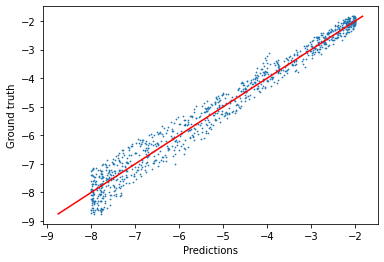

In [63]:
show_correlation(y_pred_MLP, y_test)

By adding one more hidden layer, this model with 2 hidden layers performs much better than the previous model that had just one hidden layer. This is evident from the correlation coefficient being much higher (0.987 vs 0.674) and visually, this model's predictions are closely matching the ground truth with slight over and under predictions for most of the points. Thus, you can improve performance by adding more hidden layers. 